# Building a facial recognition system from pre-trained networks



In [55]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from matplotlib import pyplot as plt
import torch
import numpy as np
import s3fs

In [11]:
mtcnn = MTCNN(keep_all=True)
img = Image.open('origProbe.jpg')
img_cropped = mtcnn(img)

In [13]:
img_cropped.shape

torch.Size([5, 3, 160, 160])

In [17]:
resnet = InceptionResnetV1(pretrained='vggface2')

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [18]:
img_embedding = resnet(img_cropped)

In [19]:
img_embedding.shape

torch.Size([5, 512])

In [54]:
fs=s3fs.S3FileSystem()
classOf25=[]
for f in fs.ls('s3://mlspace-data-521454461163/project/10FacialRecognition/datasets/midsfaces/'):
    if 'M25' in f:
        classOf25.append(f)
print(len(classOf25))

1161


In [93]:
mtcnn = MTCNN().eval()
resnet = InceptionResnetV1(pretrained='vggface2').eval().to('cuda')
ptt = PILToTensor()
allClass25Embeds = np.zeros((1161,512))
images25 = []

i = 0
for person in classOf25:
    with fs.open('s3://'+person) as image:
        img = Image.open(image)
        images25.append(img)
        img = mtcnn(img).to('cuda')
        allClass25Embeds[i,:] = resnet(img.unsqueeze(0)).detach().cpu().numpy()
        i+=1

In [57]:
allClass25Embeds = embeds

In [58]:
len(fs.ls('s3://mlspace-data-521454461163/project/10FacialRecognition/datasets/onlySD312/'))

39

In [70]:
sd312images=[]
sd312embeds = np.zeros((39,512))
i=0
for f in fs.ls('s3://mlspace-data-521454461163/project/10FacialRecognition/datasets/onlySD312/'):
    with fs.open('s3://'+f) as image:
        img = Image.open(image)
        sd312images.append(img)
        img = mtcnn(img).to('cuda')
        sd312embeds[i,:] = resnet(img.unsqueeze(0)).detach().cpu().numpy()
        i+=1

In [62]:
sd312embeds.shape

(39, 512)

In [63]:
from sklearn.neighbors import NearestNeighbors

In [95]:
nn=NearestNeighbors()
nn.fit(allClass25Embeds)

NearestNeighbors()

In [117]:
probeneighbors = nn.kneighbors(img_embedding.detach().numpy())
print(probeneighbors[1])

[[ 808  959  457  698 1051]
 [ 583  352  538  697 1058]
 [   3  284  474  965   30]
 [1040  393 1008  760  701]
 [ 269  945  262  261  655]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


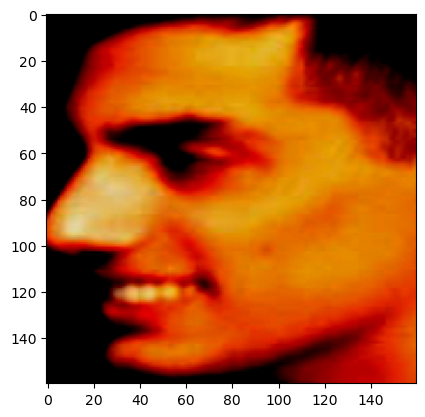

In [114]:
plt.imshow(img_cropped[0].permute(1,2,0))

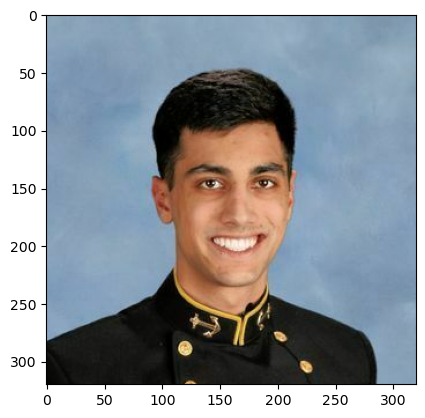

In [115]:
plt.imshow(images25[808])

In [113]:
def showMatches(probe, galleries):
    # Create a figure with 1 row and 6 columns for subplots
    fig, axs = plt.subplots(1, 6, figsize=(18, 3))

    # Plot each image on its corresponding subplot
    axs[0].imshow(probe)
    axs[0].axis('off')  # Turn off axis for cleaner display
    axs[0].set_title('Probe')

    # Draw a vertical line after the first image
    axs[0].axvline(x=0.5, color='black', linestyle='--')

    for i in range(len(galleries)):
        axs[i+1].imshow(galleries[i])
        axs[i+1].axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [120]:
probeneighbors[0]

array([[1.10442344, 1.16162124, 1.17268289, 1.18077833, 1.18929829],
       [1.04364132, 1.04729018, 1.05750381, 1.06213814, 1.06576563],
       [0.84949368, 1.01530031, 1.02198697, 1.03610043, 1.0502682 ],
       [0.94654272, 1.03595435, 1.03956993, 1.05907756, 1.05916138],
       [1.06598517, 1.15296163, 1.16003589, 1.17200467, 1.17350904]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


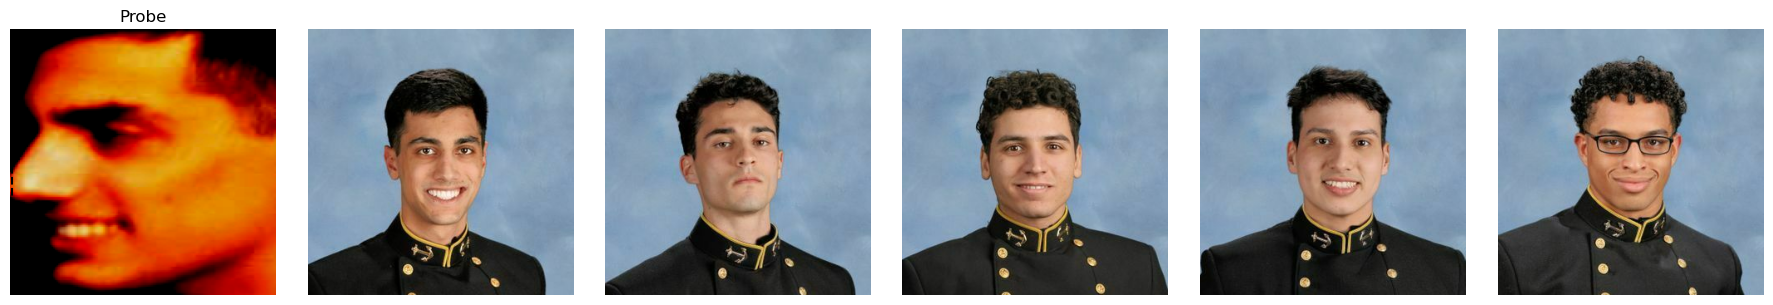

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


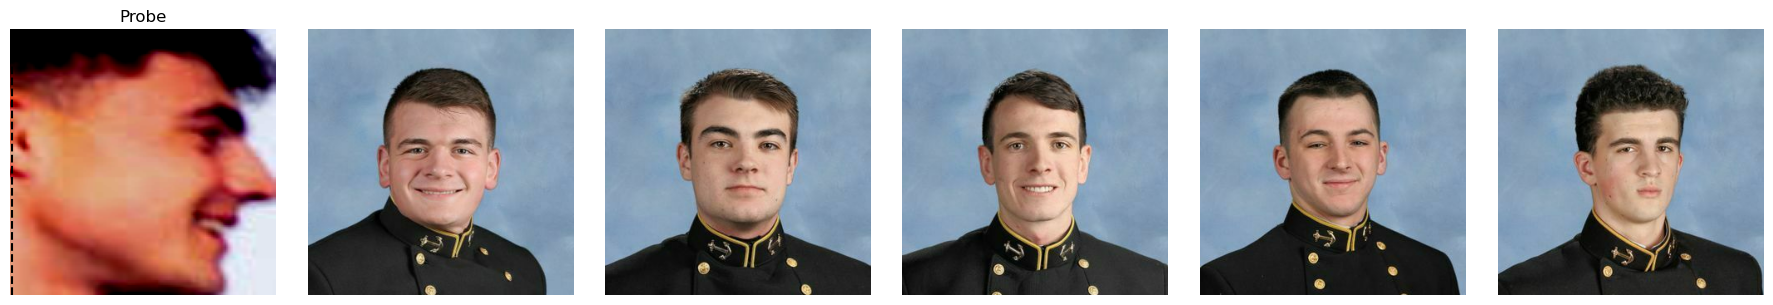

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


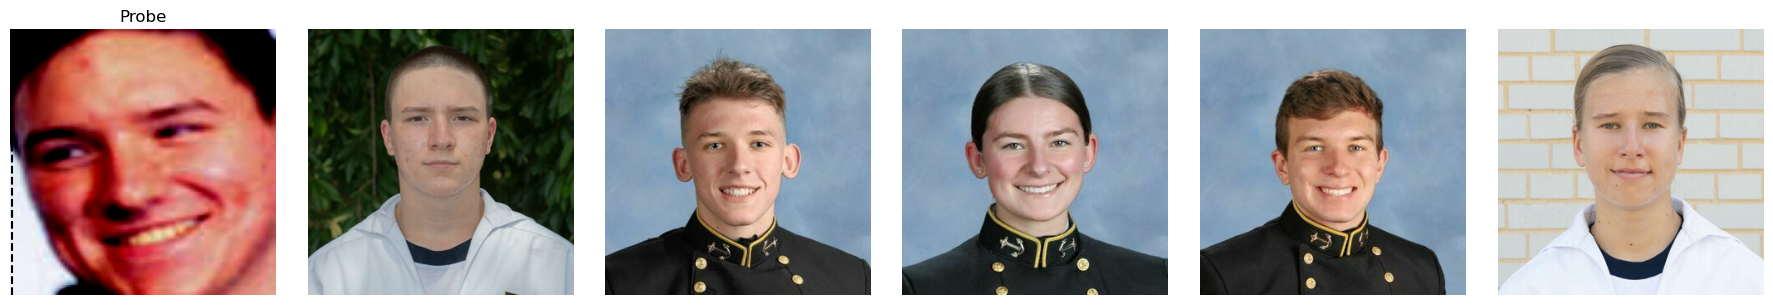

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


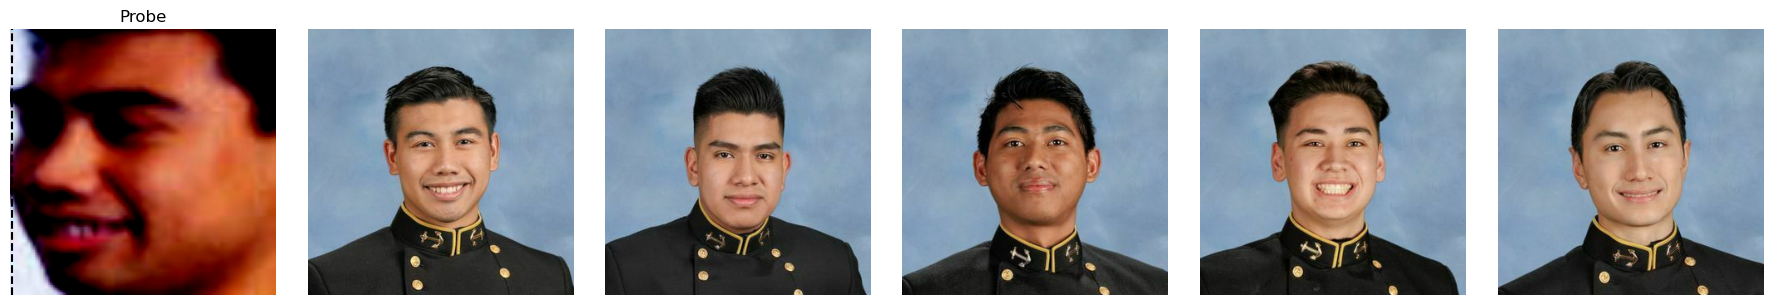

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


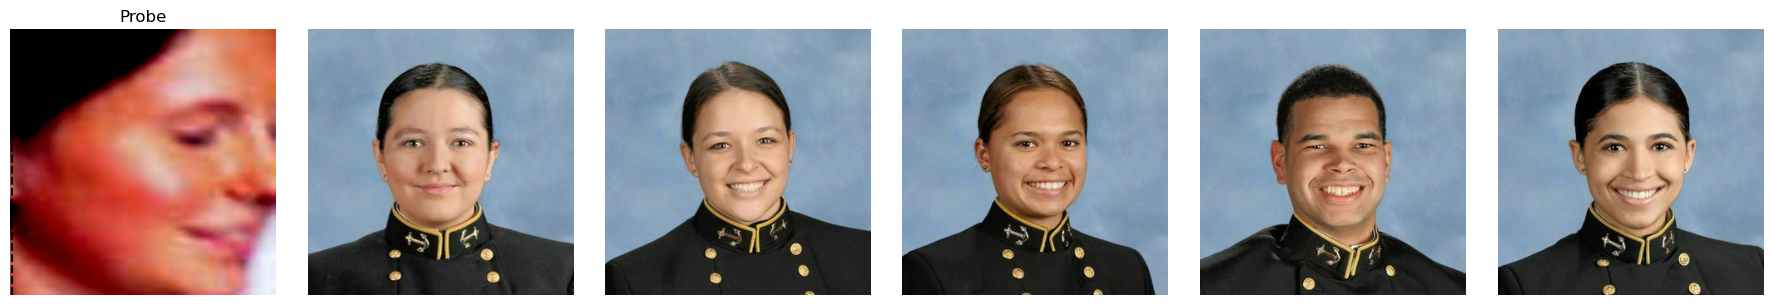

In [125]:
for j in range(len(img_cropped)):
    showMatches(img_cropped[j].permute(1,2,0), [images25[i] for i in probeneighbors[1][j]])